In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/NUST/NUST Semester 3/datasets/CV/'
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/NUST/NUST Semester 3/datasets/CV
misc  seg_pred	seg_test  seg_train


In [ ]:
!unzip intel-image-classification.zip

In [ ]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

import tensorflow as tf
import keras

In [ ]:
# Configuration
width = 150
height =150
batch_size = 64

In [ ]:
# necessary imports
import os
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (150, 150))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'seg_train/seg_train',
        target_size=(height,width),
        batch_size=batch_size,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'seg_pred/seg_pred',
        target_size=(height,width),
        batch_size=batch_size,
        class_mode='categorical')
# test_generator = test_datagen.flow_from_directory(
#         'seg_test/seg_test',
#         target_size=(height,width),
#         batch_size=batch_size,
#         class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
print(train_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
print('loading test images')
X_test, y_test = load_data('seg_test/seg_test/')

loading test images


100%|██████████| 1128/1128 [00:02<00:00, 388.78it/s]


In [ ]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dropout, Flatten, Dense, Input

In [ ]:
new_input = Input(shape=(width, height, 3))
model = applications.VGG19(weights='imagenet', include_top=False, input_tensor=new_input)
flat1  = Flatten()(model.layers[-1].output)
class1 = Dense(2048, activation='relu')(flat1)
drop1  = Dropout(0.2)(class1)
class2 = Dense(1024, activation='relu')(drop1)
drop2  = Dropout(0.2)(class2)
output = Dense(6, activation='softmax')(drop2)
# define new model  
model = Model(inputs=model.inputs, outputs=output)

for layer in model.layers[:-6]:
    layer.trainable = False

# for layer in model.layers:
#     print(layer.trainable)

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator, verbose=1)

Epoch 1/50
220/220 [==============================] - 385s 2s/step - loss: 0.5325 - accuracy: 0.8020 - val_loss: 0.3767 - val_accuracy: 0.8587
Epoch 2/50
220/220 [==============================] - 108s 489ms/step - loss: 0.5157 - accuracy: 0.8093 - val_loss: 0.4147 - val_accuracy: 0.8370
Epoch 3/50
220/220 [==============================] - 108s 489ms/step - loss: 0.4848 - accuracy: 0.8208 - val_loss: 0.3634 - val_accuracy: 0.8660
Epoch 4/50
220/220 [==============================] - 107s 485ms/step - loss: 0.4768 - accuracy: 0.8238 - val_loss: 0.3572 - val_accuracy: 0.8643
Epoch 5/50
220/220 [==============================] - 107s 484ms/step - loss: 0.4541 - accuracy: 0.8323 - val_loss: 0.3444 - val_accuracy: 0.8723
Epoch 6/50
220/220 [==============================] - 106s 482ms/step - loss: 0.4503 - accuracy: 0.8325 - val_loss: 0.3551 - val_accuracy: 0.8727
Epoch 7/50
220/220 [==============================] - 106s 483ms/step - loss: 0.4450 - accuracy: 0.8340 - val_loss: 0.3963 - va

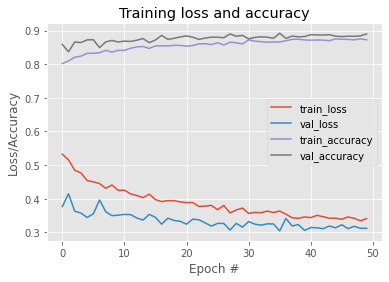

In [ ]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, history.history['loss'], label='train_loss')
plt.plot(N, history.history['val_loss'], label='val_loss')
plt.plot(N, history.history['accuracy'], label='train_accuracy')
plt.plot(N, history.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
# serialize model to JSON 
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json) 
# serialize weights to HDF5 
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
lb = LabelBinarizer()
y_test_indx = lb.fit_transform(y_test)
score = model.evaluate(X_test, y_test_indx, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

115/115 [==============================] - 25s 144ms/step - loss: 0.4725 - accuracy: 0.8327
Test Loss =  0.3526965081691742
Test Accuracy =  0.8807013034820557


In [ ]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test_indx, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[1085,    1,    0,    1,   11,   46],
       [   4, 1136,    3,    2,    9,   12],
       [   7,    3, 1084,  121,  104,   11],
       [   6,    3,  156,  951,  176,    5],
       [  11,    3,   18,   26, 1061,    9],
       [ 109,    3,    3,    1,    7, 1113]])

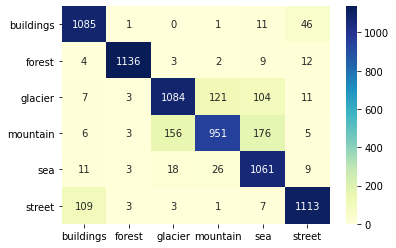

In [ ]:
import seaborn as sns
labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'] # default sorting of classes is aplanumeric
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='d', cmap="YlGnBu")

Actual Label = glacier
Predicted Label = mountain


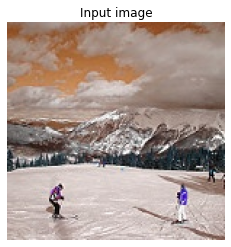

2


In [ ]:
# set index out of 10000 test images
obtained_label = np.argmax(y_pred, axis=1)
class_names = train_generator.classes

#comparison
index = 2
print("Actual Label =" , y_test[index])
print("Predicted Label =", labels[obtained_label[index]])
figr, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[index])
ax1.set_title('Input image')
plt.show()

for j in range(500):
  if(y_test[j] != labels[obtained_label[j]]):
    print(j)
    break


In [ ]:
# load json and create model
json_file = open('misc/88/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("misc/88/model.h5")
print("Loaded model from disk")

loaded_model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])

Loaded model from disk
